# Homework 4: FastPitch + GST
In this homework you will implement and train FastPitch with GST (global style token) encoder.

# Assessment

Total score for this task is 30 points:
#### FastPitch
* **7** - you filled in all the code gaps before the GST estimator block (and they seem sane to the reviewer)
* **5** - you trained FastPitch model
* **3** - you visualized the GST space

#### GST block
* **5** - you filled in all the code gaps after the GST estimator block (and they seem sane to the reviewer)
* **4** - you trained a GST estimator on the top of your FastPitch model
* **3** - your test files sound intelligible and corresponds to the text
* **3** - your test files have normal or good intonation and sound natural

The result of this work is 
* the notebook filled
* if training is successful: model checkpoint + training logs
* 16 wavfiles (15 test corpus + one about a quick brown fox).

## Dependencies & Includes

In [ ]:
!pip install librosa praat-parselmouth torch-optimizer tensorboardX Unidecode inflect wget tqdm scikit-learn

In [1]:
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
import re
import wget
import time
import shutil
import tqdm
from collections import defaultdict

from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torch_optimizer import Lamb
from torch.optim import Adam

import librosa
import soundfile as sf
import parselmouth
from scipy.io import wavfile
import IPython.display as ipd

# local imports
from hparams import HParamsFastpitch
from nv_extern.tacotron2.arg_parser import parse_tacotron2_args
from nv_extern.tacotron2.model import Tacotron2
from nv_extern.waveglow.model import WaveGlow
from nv_extern.waveglow.denoiser import Denoiser
from nv_extern.common.text.symbols import get_symbols
from nv_extern.common.text.text_processing import TextProcessing

In [2]:
assert torch.cuda.is_available(), "Need some GPU to train the model"
device = torch.device('cuda')
print("GPU found: {}".format(torch.cuda.get_device_name(device)))

GPU found: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [3]:
ljspeech_data_path = "LJSpeech-1.1"
prepr_data_path = "LJSpeech_prepr"

train_filelist_path = "filelists/train_filelist.txt"
val_filelist_path = "filelists/val_filelist.txt"


logs_dir = "logs_dir"
gst_logs_dir = "gst_logs_dir"

pretrained_models_path = "pretrained_models"

if not os.path.exists(pretrained_models_path):
    os.mkdir(pretrained_models_path)
    
synth_wavs_path = "synth_wavs"

In [4]:
_prev_bytes = 0
def bar_progress(current, total, width=80):
    global _prev_bytes
    
    pq = _prev_bytes / total
    cq = current / total
    if _prev_bytes > current or (cq - pq) * 1000 > 1:
        _prev_bytes = current
    else:
        return
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (cq * 100, current, total)
    # Don't use print() as it will print in new line every time.
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()
    
def getfile(url, dest):
    wget.download(url, dest, bar=bar_progress)

In [5]:
hparams = HParamsFastpitch({'batch_size' : 8})

Parameters redefinitions:
batch_size = 8


In [6]:
def load_from_checkpoint(model, state_dict):
    if not hasattr(model, 'module'):
        state_dict = {
            name.replace('module.', ''): param
            for name, param in state_dict.items()
        }
    else:
        for key, value in state_dict.items():
            break
        if key[:6] != 'module':
            state_dict = {
                'module.' + name :  param
                for name, param in state_dict.items()
            }
            
    model.load_state_dict(state_dict)

## Download data

In [7]:
ljs_arch="LJSpeech-1.1.tar.bz2"
taco2_url = "http://data.keithito.com/data/speech/" + ljs_arch

In [12]:
getfile(taco2_url, ljs_arch)

Downloading: 99% [2747006976 / 2748572632] bytes

In [13]:
!tar -xf {ljs_arch}

## Mel, duration and pitch extraction

### Text

In [14]:
os.mkdir(prepr_data_path)

In [8]:
def parse_filelist(fname):
    data = []
    with open(fname) as ifile:
        for l in ifile:
            fid, _, text = l.strip().split("|")
            data.append((fid, text))
    return data

In [9]:
fl = parse_filelist(os.path.join(ljspeech_data_path, "metadata.csv"))

tp = TextProcessing('english_basic', ['english_cleaners'])

In [17]:
for file_id, text in tqdm.tqdm(fl):
    text_encoded = np.array(tp.encode_text(text))
    text_path = os.path.join(prepr_data_path, file_id + ".text.npy")
    np.save(text_path, text_encoded)

100%|███████████████████████████████████| 13100/13100 [00:07<00:00, 1713.45it/s]


### Mel

In [10]:
mel_basis = librosa.filters.mel(sr=hparams.sample_rate, 
                                n_fft=hparams.n_fft, 
                                n_mels=hparams.n_mel_channels,
                                fmin=hparams.min_frequency, 
                                fmax=hparams.max_frequency)


def mel_spectrogram(audio, hparams):
    def linear_to_mel(s):
        return np.dot(mel_basis, s)
    
    def amp_to_db(x):
        return np.log(np.maximum(1e-5, x))
    
    spectr = librosa.stft(audio, 
                            n_fft=hparams.n_fft, 
                            hop_length=hparams.hop_length,
                            win_length=hparams.win_length,
                            window=hparams.window)
    
    spectr = np.abs(spectr)
    mel_spectr = amp_to_db(linear_to_mel(spectr))
    return mel_spectr


def get_mel(pcm_path, mel_path, hparams):
    audio, sr = sf.read(pcm_path, dtype='float32')
    audio = librosa.resample(y=audio, orig_sr=sr, target_sr=hparams.sample_rate)
    np.save(mel_path, mel_spectrogram(audio, hparams))


def extract_mels(wav_path, out_dir, hparams):
    for filename in tqdm.tqdm(os.listdir(wav_path)):
        file_id = re.search(r"(.*).wav", filename).group(1)
        mel_path = os.path.join(out_dir, file_id + ".mel")
        get_mel(os.path.join(wav_path, filename), mel_path, hparams)

In [22]:
extract_mels(os.path.join(ljspeech_data_path, "wavs"), prepr_data_path, hparams)

100%|████████████████████████████████████| 13100/13100 [02:00<00:00, 108.58it/s]


### Durations extraction

As it was said on the lecture, we can extract durations with Tacotron model.

Firstly, we need to download it:

In [11]:
taco2_url = "https://api.ngc.nvidia.com/v2/models/nvidia/tacotron2_pyt_ckpt_amp/versions/19.12.0/files/nvidia_tacotron2pyt_fp16.pt"
taco2_path = os.path.join(pretrained_models_path, "tacotron2")

In [24]:
getfile(taco2_url, taco2_path)

Downloading: 99% [338214912 / 338398023] bytes

Now we should extract durations by batch-processing our records with tacotron,

Then, we should store them into npy

In [12]:
class TacoDataset(torch.utils.data.Dataset):
    def __init__(self, directory):
        super(TacoDataset, self).__init__()
        self.directory = directory
        self.mel_paths = []
        self.text_paths = []
        self.file_ids = []
        
        for filename in os.listdir(directory):
            if ".text.npy" not in filename:
                continue
            file_id = re.search(r"(.*).text.npy", filename).group(1)
            self.file_ids.append(file_id)
            text_path = os.path.join(self.directory, filename)
            self.text_paths.append(text_path)
            self.mel_paths.append(text_path.replace(".text.npy", ".mel.npy"))
            
            
    def __getitem__(self, idx):
        text = torch.IntTensor(np.load(self.text_paths[idx]))
        mel = torch.FloatTensor(np.load(self.mel_paths[idx]))
        file_id = self.file_ids[idx]
        return (text, mel, file_id)
    
    def __len__(self):
        return len(self.text_paths)

    
class TacoCollate:
    def __init__(self, n_mel_channels):
        self.n_mel_channels = n_mel_channels
        
    def  __call__(self, batch):
        batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        
        max_text_length = max([text.size(0) for text, *_ in batch])
        max_mel_length = max([mel.size(1) for _, mel, *_ in batch])
        
        texts_padded = torch.LongTensor(len(batch), max_text_length).zero_()
        text_lengths = torch.LongTensor(len(batch)).zero_()
        mels_padded = torch.FloatTensor(len(batch), self.n_mel_channels, max_mel_length).zero_()
        mel_lengths = torch.LongTensor(len(batch)).zero_()
        
        file_ids = []
        
        for i, (text, mel, file_id) in enumerate(batch):
            texts_padded[i, :text.size(0)] = text
            text_lengths[i] = text.size(0)
            mels_padded[i, :, :mel.size(1)] = mel
            mel_lengths[i] = mel.size(1)
            file_ids.append(file_id)
            
        max_len = torch.max(text_lengths.data).item()
        return (texts_padded, text_lengths, mels_padded, max_len, mel_lengths), file_ids

You can get good alignment by dynamic programming.
Here, you should write some code that will find the trajectory in attention matrix that maximizes cost:
$$(j_i) = \mathsf{argmax} (Cost) = \mathsf{argmax} \prod_{i=1}^{N_{frames}} A_{i j_i}$$
where:
$$j_{i+1} = j\;or\;j+1$$
$$j_1 = 1$$
$$j_{N_{frames}} = N_{graphemes}$$


In [13]:
def dp_alignment(attention):
    """
    Here you are given with an attention prob matrix
        with a shape of N_frames X N_graphemes
        
    You should compute the optimal way according to the formula above with DP.
    With the optimal way (sequence j_i) computed you should return durations.
    So, duration of j-th gratheme == #(i: j_i == j) -- number of frames at which
        our optimal way is 'stuck' at the grapheme.
    These durations, as an integer numpy array should be returned from the function.
    """
    
    n_frames, n_graphemes = attention.shape

    dp = np.zeros((n_frames, n_graphemes))
    backtrack = np.zeros((n_frames, n_graphemes), dtype=int)

    dp[0, :] = -np.inf
    dp[0, 0] = attention[0, 0]

    for i in range(1, n_frames):
        for j in range(n_graphemes):
            stay = dp[i - 1, j]
            move = dp[i - 1, j - 1] if j > 0 else -np.inf
            dp[i, j] = max(stay, move) + np.log(attention[i, j])

            if dp[i, j] == stay + np.log(attention[i, j]):
                backtrack[i, j] = j
            else:
                backtrack[i, j] = j - 1

    j_arr = np.zeros(n_frames, dtype=int)
    j_arr[-1] = n_graphemes - 1

    for i in range(n_frames - 2, -1, -1):
        j_arr[i] = backtrack[i + 1, j_arr[i + 1]]

    durations = np.zeros(n_graphemes, dtype=int)
    for j in range(n_graphemes):
        durations[j] = np.sum(j_arr == j)

    return durations.astype(int)

In [14]:
def extract_durations(taco_checkpoint_path, data_path, hparams, batch_size=8):
    taco_checkpoint = torch.load(taco_checkpoint_path)
    taco_model = Tacotron2(**taco_checkpoint['config']).to(device)
    load_from_checkpoint(taco_model, taco_checkpoint['state_dict'])
    taco_model.eval()

    taco_dataset = TacoDataset(data_path)
    taco_collate = TacoCollate(hparams.n_mel_channels)
    taco_dataloader = DataLoader(taco_dataset, batch_size=batch_size, collate_fn=taco_collate)
    
    for batch, file_ids in tqdm.tqdm(taco_dataloader):
        with torch.no_grad():
            batch = [elem.to(device) 
                     if torch.is_tensor(elem)
                     else elem
                     for elem in batch]
            _, text_lengths, _, _, mel_lengths = batch
            
            *_, alignments = taco_model.forward(batch)
            alignments = alignments.cpu().numpy()
            
            for j, ali in enumerate(alignments):
                dur_path = os.path.join(data_path, file_ids[j] + ".dur")
                
                ali = ali[: mel_lengths[j], : text_lengths[j]]
                durations = dp_alignment(ali)
                np.save(dur_path, durations)

In [45]:
extract_durations(taco2_path, prepr_data_path, hparams, batch_size=32)

100%|█████████████████████████████████████████| 410/410 [26:15<00:00,  3.84s/it]


Check yourself: Average "a" duration in the corpus should not be far from 6.782268

In [46]:
cnt = 0
sum = 0
for i, _ in tqdm.tqdm(fl):
    text = np.load(os.path.join(prepr_data_path, i + ".text.npy"))
    dur = np.load(os.path.join(prepr_data_path, i + ".dur.npy"))
    for c, d in zip(text, dur):
        if c == 38:
            cnt += 1
            sum += d
mean_a_duration = sum / cnt
print("Mean 'a' duration in the corpus is {} frames".format(mean_a_duration))
assert np.abs(mean_a_duration - 6.7823) < 0.01

100%|███████████████████████████████████| 13100/13100 [00:01<00:00, 9631.71it/s]

Mean 'a' duration in the corpus is 6.77854325916549 frames


### Pitch extraction

Here we use parselmouth pitch extractor, pad and store the extracted F-0 values into npy files

In [15]:
def maybe_pad(vec, l):
    assert np.abs(vec.shape[0] - l) <= 3
    vec = vec[:l]
    if vec.shape[0] < l:
        vec = np.pad(vec, pad_width=(0, l - vec.shape[0]))
    return vec

In [16]:
def calculate_pitch(wav_path, durs):
    durs = durs.astype(int)
    mel_len = durs.sum().astype(int)
    durs_cum = np.cumsum(np.pad(durs, (1, 0))).astype(int)

    snd = parselmouth.Sound(wav_path)
    pitch = snd.to_pitch(time_step=snd.duration / (mel_len + 3)).selected_array["frequency"]
    assert np.abs(mel_len - pitch.shape[0]) <= 1.0

    # Average pitch over characters
    pitch_char = np.zeros((durs.shape[0],), dtype=float)
    for idx, a, b in zip(range(int(mel_len)), durs_cum[:-1], durs_cum[1:]):
        values = pitch[a:b][np.where(pitch[a:b] != 0.0)[0]]
        pitch_char[idx] = np.mean(values) if len(values) > 0 else 0.0

    pitch_char = maybe_pad(pitch_char, len(durs))

    return pitch_char

In [17]:
def extract_pitch(wavs_path, preproc_data_path):
    for filename in tqdm.tqdm(os.listdir(wavs_path)):
        file_id = re.search(r"(.*).wav", filename).group(1)
        wav_path = os.path.join(wavs_path, filename)
        dur_path = os.path.join(preproc_data_path, file_id + ".dur.npy")
        pitch_path = os.path.join(preproc_data_path, file_id + ".pt.npy")
      
        dur = np.load(dur_path)
        pitch = calculate_pitch(str(wav_path), dur)
        np.save(pitch_path, pitch)

In [51]:
extract_pitch(os.path.join(ljspeech_data_path, "wavs"), prepr_data_path)

 35%|█████████████▎                        | 4603/13100 [02:15<04:36, 30.75it/s]

## Data utils

Some helper classes for training

In [18]:
LJSPEECH_MEAN = 218.44949768191876
LJSPEECH_STD = 64.85769765940508

In [19]:
class FastPitchDataset(torch.utils.data.Dataset):
    """
    Provides random access to the samples
    returns data in the form of (text, mel, duration, pitch)
    """
    def __init__(self, directory, filelist_path):
        super(FastPitchDataset, self).__init__()
        self.directory = directory
        self.mel_paths = []
        self.pitch_paths = []
        self.dur_paths = []
        self.text_paths = []

        with open(filelist_path, "r") as filelist:
            file_ids = filelist.readlines()
        file_ids = [elem.strip() for elem in file_ids] 
        
        for file_id in file_ids:
            text_path = os.path.join(directory, file_id + ".text.npy")
            self.text_paths.append(text_path)
            self.pitch_paths.append(text_path.replace(".text.npy", ".pt.npy"))
            self.dur_paths.append(text_path.replace(".text.npy", ".dur.npy"))
            self.mel_paths.append(text_path.replace(".text.npy", ".mel.npy"))
        
    def __getitem__(self, idx):
        text = torch.IntTensor(np.load(self.text_paths[idx]))
        mel = torch.FloatTensor(np.load(self.mel_paths[idx]))
        dur = torch.FloatTensor(np.load(self.dur_paths[idx]))
        pitch = torch.FloatTensor(np.load(self.pitch_paths[idx]))
        
        pitch[pitch != 0] = (pitch[pitch != 0] - LJSPEECH_MEAN) / LJSPEECH_STD

        return (text, mel, dur, pitch)
    
    def __len__(self):
        return len(self.text_paths)
    
    
class FastPitchCollate:
    """
    Groups and pads the date to the batches,
    adds lengths of texts and mels tensors to the batch info
    """
    def __init__(self, n_mel_channels):
        self.n_mel_channels = n_mel_channels

    def __call__(self, batch):
        max_text_length = max([text.size(0) for text, *_ in batch])
        max_mel_length = max([mel.size(1) for _, mel, *_ in batch])
    
        texts_padded = torch.LongTensor(len(batch), max_text_length).zero_()
        text_lengths = torch.LongTensor(len(batch)).zero_()
        mels_padded = torch.FloatTensor(len(batch), self.n_mel_channels, max_mel_length).zero_()
        mel_lengths = torch.LongTensor(len(batch)).zero_()
        dur_padded = torch.zeros_like(texts_padded, dtype=batch[0][2].dtype)
        pitch_padded = torch.zeros(dur_padded.size(0), dur_padded.size(1), dtype=batch[0][3].dtype)
        
        for i, (text, mel, dur, pitch) in enumerate(batch):
            texts_padded[i, :text.size(0)] = text
            text_lengths[i] = text.size(0)
            mels_padded[i, :, :mel.size(1)] = mel
            mel_lengths[i] = mel.size(1)
            dur_padded[i, :dur.shape[0]] = dur
            pitch_padded[i, :pitch.shape[0]] = pitch
          
        return (texts_padded,
            text_lengths,
            mels_padded,
            mel_lengths,
            dur_padded,
            pitch_padded)

In [20]:
def batch_to_device(batch, device):
    """
    Pushes all the numeric data to GPU
    Splits input and output data of the model
    """
    (texts, 
     text_lengths, 
     mels, 
     mel_lengths, 
     dur,  
     pitch
    ) = [tensor.to(device) if tensor is not None
               else None
               for tensor in batch]
    
    x = (texts, text_lengths, mels, mel_lengths, dur, pitch)
    y = (mels, dur, text_lengths, pitch)
    return x, y

In [21]:
def mask_from_lens(lengths, max_len=None):
    """
    With mels' or texts' lengths given creates a 0-1 mask for losses
    """
    if max_len is None:
        max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, device=lengths.device)
    mask = (ids < lengths.unsqueeze(1))
    return mask

### Loss function

In [22]:
class FastPitchLoss(nn.Module):
    def __init__(self, hparams):
        super(FastPitchLoss, self).__init__()
        self.dur_predictor_loss_scale = hparams.dur_predictor_loss_scale
        self.pitch_predictor_loss_scale = hparams.pitch_predictor_loss_scale

    def forward(self, model_out, targets, meta_agg='mean'):
        """
        Here you get
        * model_out, which is a tuple of
            mel_output, decoding_mask, predicted_duration, log_pred_duration and predicted_pitch
        * targets, which is also a tuple:
            mel_target, duration_target, duration_lengths, pitch_target
        
        you should compute loss - a weighted (look at constructor and hparams) sum of
            (masked) l2 mels, pitch and durations losses
        also, to draw graphs you should return the components separately - in a dict meta - kv struct with keys:
            * loss
            * mel_loss
            * duration_predictor_loss
            * pitch_loss
            * duration_l1_error
        """
        assert meta_agg in ('sum', 'mean')
        
        mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred = model_out
        mel_tgt, dur_tgt, dur_lens, pitch_tgt = targets
        mel_tgt.requires_grad = False
        # (B,H,T) => (B,T,H)
        mel_tgt = mel_tgt.transpose(1, 2)

        dur_mask = mask_from_lens(dur_lens, max_len=dur_tgt.size(1))
        
        mel_loss = nn.MSELoss(reduction='none')(mel_out, mel_tgt)
#         print('Mel loss:', mel_loss.shape, dec_mask.shape)
        mel_loss = (mel_loss * dec_mask.unsqueeze(1)).sum() / dec_mask.sum()
        
        pitch_loss = nn.MSELoss(reduction=meta_agg)(pitch_pred, pitch_tgt)
        
        log_dur_loss = nn.MSELoss(reduction='none')(log_dur_pred, torch.log(1 + dur_tgt))
        log_dur_loss = (log_dur_loss * dur_mask).sum() / dur_mask.sum()
#         print('Duration loss:', log_dur_loss.shape, dur_mask.shape)
        
        loss = (mel_loss
                + pitch_loss * self.pitch_predictor_loss_scale
                + log_dur_loss * self.dur_predictor_loss_scale)
       
        meta = {
            'loss':                    loss.clone().detach(),
            
            'mel_loss':                mel_loss.clone().detach(),
            
            'duration_predictor_loss': log_dur_loss.clone().detach(),
            
            'pitch_loss':              pitch_loss.clone().detach(),
            
            'duration_l1_error':       (torch.abs(dur_pred - dur_tgt).sum() 
                                           / dur_mask.sum()).detach(),
        }
       
        if meta_agg == 'sum':
            for key in meta:
                if key == 'pitch_loss':
                    continue
                meta[key] *= dec_mask.sum()

        return loss, meta

### Logger

In [23]:
class FastpitchLogger:
    """
    Logger. Saves/loads model, flushes on validation, can log gradients (useful for debugging the core AM model)
    """
    
    def __init__(self, logdir, hparams):
        self.eval_interval = hparams.eval_interval
        self.global_checkpoint_coef = hparams.global_checkpoint_coef
        self.logdir = logdir
        
        self.train_logger = SummaryWriter(os.path.join(logdir, 'train'))
        self.val_logger = SummaryWriter(os.path.join(logdir, 'val'))


    def log_grads(self, step, model):
            norms = [p.grad.norm().item() for p in model.parameters()
                     if p.grad is not None]
            for stat in ('max', 'min', 'mean'):
                self.train_logger.add_scalar(f'grad_{stat}', getattr(np, stat)(norms), step)

    def log(self, logger, step, meta):
        for k, v in meta.items():
            logger.add_scalar(k, 
                            v.item() if hasattr(v, 'item') else v, 
                            step)
    
    def log_training(self, step, meta):
        print(f"train : {meta['step']}  loss {meta['loss']:.4f}")
        self.log(self.train_logger, step, meta)
            
        
    def log_validation(self, step, meta):
        print(f"val : {meta['step']}  loss {meta['loss']}")
        self.log(self.val_logger, step, meta)
            
        for w in self.train_logger.all_writers.values():
            w.flush()
        for w in self.val_logger.all_writers.values():
            w.flush()
            
    def step_to_path(self, step):
        return os.path.join(self.logdir, f"{step:07d}_snapshot.pth")
            
    @staticmethod
    def load_last_checkpoint(logdir):
        steps = [
            int(filename.replace('_snapshot.pth', ''))
            for filename in os.listdir(logdir)
            if '_snapshot.pth' in filename
        ]

        if len(steps) == 0:
            return {
                'step': 0,
                'state_dict': None
            }

        return torch.load(os.path.join(logdir, f"{max(steps):07d}_snapshot.pth"))
            
 
    def save_checkpoint(self, model, optimizer, step, hparams):
        checkpoint = {
            'step': step,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'params': hparams.__dict__
        }
        
        torch.save(checkpoint, self.step_to_path(step))

        # remove unnecessary snapshots
        if step > self.eval_interval and (step - self.eval_interval) % (self.global_checkpoint_coef * self.eval_interval):
            os.remove(self.step_to_path(step - self.eval_interval))

## Model

It is highly recommended to go briefly through FastPitch paper https://arxiv.org/abs/2006.06873 before doing the next section

### FFTransformer 

Here is the core part of FastPitch model.
You should implement self-attention block here.

Note: the classes below are provided for your convenience. You are free to re-write everything in your own style if your architecture will work and you will implement in your code main idea of FastPitch (FFT encoder and decoder, duration and pitch prediction in between)

Here you need to implement sin-cos pos embeddings:
$$PE[p, 2 i] = sin\left(\frac{p}{10000^{2i/d_{model}}}\right)$$
$$PE[p, 2 i + 1] = cos \left(\frac{p}{10000^{2i/d_{model}}}\right)$$

In [24]:
class PositionalEmbedding(nn.Module):
    """
    Sin and cos positional embeddings
    """
    BASE = 10000
    
    def __init__(self, d_model):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model

    """
    * pos_seq - 1...N array
    """
    def forward(self, pos_seq):
        device = pos_seq.device
        pos_seq = pos_seq.unsqueeze(-1)
        
        div_term = torch.pow(self.BASE, torch.arange(0, self.d_model, 2, device=device).float() / self.d_model)
        pos_embedding = torch.zeros((pos_seq.size(0), self.d_model), device=device)
        
        pos_embedding[:, 0::2] = torch.sin(pos_seq / div_term)
        pos_embedding[:, 1::2] = torch.cos(pos_seq / div_term)
        
        return pos_embedding

In [25]:
class PositionwiseConvFF(nn.Module):
    """
    This position-wise convolutional layer
    It is a sequence:
    * Conv1d, d_model -> d_inner
    * ReLU
    * Conv1d, d_inner -> d_model
    * Dropout
    * Residual (+input)
    * LayerNorm
    """
    
    def __init__(self, d_model, d_inner, kernel_size, dropout):
        super(PositionwiseConvFF, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(d_model, d_inner, kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Conv1d(d_inner, d_model, kernel_size, padding=(kernel_size - 1) // 2),
            nn.Dropout(dropout)
        )
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inp):
        # (B, C, L) --> (B, L, C)
        residual = inp
        inp = inp.transpose(1, 2)
        output = self.conv_net(inp)
        # (B, L, C) --> (B, C, L)
        output = output.transpose(1, 2)
        output = self.layer_norm(output + residual)
        return output

In [26]:
class FFTransformer(nn.Module):
    """
    Here, you should implement the sequence:
    * embeddings of the categorical input, if embed_input is True
    * dropout(input + embeddings), if dropemb is not 0
    * n_layers of (multi-head self-attention + dropout + layernorm + pos-wise convFF)
    * all this should be masked according to the lengths
    
    Parameters:
    * n_symbols - number of symbols (in case of cat input)
    * n_layer - self-att layers
    * d_model - outer dim, n_embedding for graphemes, n_mel for audio
    * n_head - number of attention heads
    * d_head - size of each head
    * kernel size - pos-wise convolution kernel size
    * dropout - DO after the self-attention
    * dropatt - DO at self-attention probs
    * dropemb - DO after the positional embeddings addition
    * embed_input - if true, input is treated as categorical and additional nn.Embeddings should be added
    * pad_idx - only for embed_input = true: special value categorical input are padded with
    
    """
    def __init__(
        self,
        n_symbols,
        n_layer,
        n_head,
        d_model,
        d_head,
        d_inner,
        kernel_size,
        dropout,
        dropatt,
        dropemb=0.0,
        embed_input=True,
        pad_idx=0
    ):
        super(FFTransformer, self).__init__()

        self.embed_input = embed_input
        self.pad_idx = pad_idx

        if embed_input:
            self.word_emb = nn.Embedding(n_symbols, d_model, padding_idx=pad_idx)
        else:
            self.word_emb = None

        self.pos_emb = PositionalEmbedding(d_model)
        self.dropemb = nn.Dropout(dropemb) if dropemb > 0 else nn.Identity()
        
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': nn.MultiheadAttention(embed_dim=d_model, num_heads=n_head, dropout=dropatt),
                'dropout_attn': nn.Dropout(dropout),
                'conv_ff': PositionwiseConvFF(d_model, d_inner, kernel_size, dropout),
                'layer_norm_attn': nn.LayerNorm(d_model),
                'layer_norm_ff': nn.LayerNorm(d_model),
            })
            for _ in range(n_layer)
        ])
        
    def forward(self, dec_inp, mel_lens=None):
        """
        * dec_inp - input, continuous or categorical
        * mel_lens - for embed_input = False: lengths of input, need for padding
        Return:
        * tuple: processed output and padding bitmask
        """
        if self.word_emb is None:
            inp = dec_inp
            mask = mask_from_lens(mel_lens).unsqueeze(2)
        else:
            inp = self.word_emb(dec_inp)
            mask = (dec_inp != self.pad_idx).unsqueeze(2)
        
#         print('Input and mask shape:', inp.shape, mask.shape)
        pos_seq = torch.arange(inp.size(1), device=inp.device, dtype=inp.dtype)
        pos_emb = self.pos_emb(pos_seq).unsqueeze(0)
        
#         print('Positional Embedding 2:', pos_emb.shape)
        pos_emb = pos_emb * mask

        inp = inp + pos_emb
        inp = self.dropemb(inp)

        out = inp.transpose(0, 1)

        attn_mask = mask.squeeze(2)

        for layer in self.layers:
            residual = out
            out, _ = layer['self_attn'](out, out, out, key_padding_mask=~attn_mask.bool())
            out = residual + layer['dropout_attn'](out)
            out = layer['layer_norm_attn'](out)

            residual = out
            out = layer['conv_ff'](out.transpose(0, 1)).transpose(0, 1)
            out = layer['layer_norm_ff'](residual + out)

        out = out.transpose(0, 1)
        
        return out, mask

## GST: style token

It is recommended for you to use already implemented FFT block as a GST encoder.

For the details - look in lecture and/or paper https://arxiv.org/pdf/1803.09017.pdf

In [27]:
class GST(nn.Module):
    def __init__(self, hparams):
        super(GST, self).__init__()

        self.encoder = FFTransformer(
            n_symbols=None,
            n_layer=hparams.gst_n_layers,
            n_head=hparams.gst_n_heads,
            d_model=hparams.n_mel_channels,
            d_head=hparams.gst_d_head,
            d_inner=hparams.gst_conv1d_filter_size,
            kernel_size=hparams.gst_conv1d_kernel_size,
            dropout=hparams.p_gst_dropout,
            dropatt=hparams.p_gst_dropatt,
            dropemb=hparams.p_gst_dropemb,
            embed_input=False
        )
        
        self.token_embedding = nn.Parameter(
            torch.randn(hparams.style_token_count, hparams.symbols_embedding_dim)
        )
        self.token_projection = nn.Linear(hparams.symbols_embedding_dim, hparams.n_mel_channels)
        self.query_projection = nn.Linear(hparams.n_mel_channels, hparams.symbols_embedding_dim)
        
    def forward(self, mels, mel_lengths):
        """
        Should take GT mels and return style embeddings and attention probs
        
        mel-invariant tokens should be keys in the attention here
        and encoder output -- the query
        
        
        Please note that you should prevent unlimited growth of tokens magnitude somehow
        E.g. you can shrink them with some restrictive function:
            attention_keys = tanh(tokens_embeddings)
        """
        
        # (batch, seq_len, mel_channels)
        mels_enc, _ = self.encoder(mels, mel_lengths) 
        
        # (n_tokens, token_dim)
        token_embs = torch.tanh(self.token_embedding)
        
        # (batch, seq_len, token_dim)
        query = self.query_projection(mels_enc)
        # (batch, seq_len, n_tokens)
        attention_logits = torch.matmul(query, token_embs.T)
        mask = (torch.arange(mels_enc.size(1), device=mels_enc.device)[None, :] < mel_lengths[:, None]).float()
        attention_logits = attention_logits * mask.unsqueeze(-1)
        
        # (batch, seq_len, n_tokens)
        alphas = F.softmax(attention_logits, dim=-1)
        # (batch, seq_len, mel_channels)
        style_embed = torch.matmul(alphas, token_embs)
        
        return style_embed, alphas

## FastPitch
#### Temporal Predictor  (predicts a single float per each temporal location)

In [28]:
class ConvReLUNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, dropout=0.0):
        super(ConvReLUNorm, self).__init__()
        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size,
                                    padding=(kernel_size // 2))
        self.norm = torch.nn.LayerNorm(out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, signal):
        out = F.relu(self.conv(signal))
        out = self.norm(out.transpose(1, 2)).transpose(1, 2)
        return self.dropout(out)
    

class TemporalPredictor(nn.Module):
    """
    Regressor head
    A couple of conv+reLU+layernorm blocks + projection to answer
    """
    def __init__(self, input_size, filter_size, kernel_size, dropout, n_layers=2):
        super(TemporalPredictor, self).__init__()

        self.layers = nn.Sequential(
            *[
                ConvReLUNorm(
                    input_size if i == 0 else filter_size,
                    filter_size,
                    kernel_size=kernel_size,
                    dropout=dropout,
                )
                for i in range(n_layers)
            ]
        )
        self.fc = nn.Linear(filter_size, 1, bias=True)

    def forward(self, enc_out, enc_out_mask):
        out = enc_out * enc_out_mask
        out = self.layers(out.transpose(1, 2)).transpose(1, 2)
        out = self.fc(out) * enc_out_mask
        return out.squeeze(-1)

In [29]:
def regulate_len(durations, enc_out):
    """
    Here you should write the part with upsample:
    Parameters:
    * durations - predicted/gt durations array
    * enc_out - encoder embeddings you need to upsample
    Returns tuple:
    * encoder upsampled states
    * frame_lengths - sums over T of durations
    
    """
    durations = durations.long()

    frame_lengths = durations.sum(dim=1)
    enc_repeated = []

    for batch_idx in range(enc_out.size(0)):
        enc_repeated.append(
            torch.cat([enc_out[batch_idx, t].unsqueeze(0).repeat(durations[batch_idx, t].item(), 1) 
                       for t in range(enc_out.size(1))], dim=0)
        )
    
    enc_repeated = pad_sequence(enc_repeated, batch_first=True)
    return enc_repeated, frame_lengths

In [46]:
class FastPitch(nn.Module):
    """
    Here you need to construct and infer FP net
    Note that predicted f0 should be feeded into decoder through convolution with a small kernel
    """
    def __init__(self, hparams : HParamsFastpitch):
        super(FastPitch, self).__init__()

        self.encoder = FFTransformer(
            n_symbols=hparams.n_symbols,
            n_layer=hparams.in_fft_n_layers,
            n_head=hparams.in_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.in_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.in_fft_conv1d_kernel_size,
            dropout=hparams.p_in_fft_dropout,
            dropatt=hparams.p_in_fft_dropatt,
            dropemb=hparams.p_in_fft_dropemb,
            embed_input=True,
            pad_idx=hparams.pad_idx)

        self.duration_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.dur_predictor_filter_size,
            kernel_size=hparams.dur_predictor_kernel_size,
            dropout=hparams.p_dur_predictor_dropout,
            n_layers=hparams.dur_predictor_n_layers,
        )

        self.decoder = FFTransformer(
            n_symbols=hparams.n_symbols,
            n_layer=hparams.out_fft_n_layers,
            n_head=hparams.out_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.out_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.out_fft_conv1d_kernel_size,
            dropout=hparams.p_out_fft_dropout,
            dropatt=hparams.p_out_fft_dropatt,
            dropemb=hparams.p_out_fft_dropemb,
            embed_input=False,
            pad_idx=hparams.pad_idx
        )

        self.pitch_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.pitch_predictor_filter_size,
            kernel_size=hparams.pitch_predictor_kernel_size,
            dropout=hparams.p_pitch_predictor_dropout,
            n_layers=hparams.pitch_predictor_n_layers,
        )
        
        """
        Here you need to declare all additional layers you need
        Don't forget about GST module
        """
        self.gst = GST(hparams)
        self.pitch_projection = nn.Conv1d(1, hparams.symbols_embedding_dim, kernel_size=3, padding=1)
        self.projection = nn.Linear(hparams.symbols_embedding_dim, hparams.n_mel_channels)
            
    def forward(self, inputs, use_gt_durations=True, use_gt_pitch=True, max_duration=75):
        """
        Inputs:
        * inputs - tuple of:
            * text - texts
            * text_lengths - lengths for padding
            * mel_tgt - targets for melspec
            * mel_lengths - for padding
            * dur_tgt - gt duration
            * pitch tgt - gt pitch
        * use_gt_durations and use_gt_pitch - True for teache-forcing (train and validation estimation)
        * max_duration - maximum possible duration
        """
        text, text_lengths, mel_tgt, mel_lengths, dur_tgt, pitch_tgt = inputs

        """
        Here you should wrtie the code for encoder
        Internal state should be (before the upsampling):
            enc_state = encoded_text + gst_style + conv(pitch)
        
        """
        enc_output, enc_mask = self.encoder(text, text_lengths)
#         print('Encoder output and mask:', enc_output.shape, enc_mask.shape)
#         print('MEL target and lengths', mel_tgt.shape, mel_lengths.shape)
        
        mel_tgt = mel_tgt.transpose(1, 2)
        gst_style, _ = self.gst(mel_tgt, mel_lengths)
#         print('GST Style output:', gst_style.shape)
        gst_style = gst_style.mean(dim=1, keepdim=True)
        
        enc_and_style = enc_output + gst_style
#         print('Enc_and_style shape:', enc_and_style.shape)
        
        pitch_pred = self.pitch_predictor(enc_and_style, enc_mask)
    
        """
        Duration is predicted in log-scale
        """
        log_dur_pred = self.duration_predictor(enc_and_style, enc_mask)
        dur_pred = torch.clamp(torch.exp(log_dur_pred) - 1, 0, max_duration)
        
        if use_gt_pitch and pitch_tgt is not None:
            pitch_conv = pitch_tgt
        else:
            pitch_conv = pitch_pred
        
#         print('Pitch shape:', pitch_conv.shape, pitch_pred.shape, pitch_tgt.shape)
        enc_state = enc_and_style + pitch_conv.unsqueeze(2)

        upsampled, dec_lens = regulate_len(
            dur_tgt if use_gt_durations else dur_pred, enc_state)
    
        dec_out, dec_mask = self.decoder(upsampled, dec_lens)
        mel_out = self.projection(dec_out)
        
        return mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred
    
    def infer(self, inputs, gst_estimator):
        """
        Here you should write the code for FP inference
        Inputs:
        * inputs - text and texts_lengths
        * gst_estimator - nn.Module that predicts style from (encoded_text, text_lengths)
        Returns:
        * mel_output
        """
        text, text_lengths = inputs
        encoder_output, enc_mask = self.encoder(text, text_lengths)
        
        gst_pred = gst_estimator.forward(encoder_output, text_lengths)
        enc_and_style = encoder_output + gst_pred.unsqueeze(1)
#         print('Enc and style shape:', encoder_output.shape, gst_pred.shape)
        
        log_dur_pred = self.duration_predictor(enc_and_style, enc_mask)
        dur_pred = torch.clamp(torch.exp(log_dur_pred) - 1, min=0)

        pitch_pred = self.pitch_predictor(enc_and_style, enc_mask)
        pitch_conv = self.pitch_projection(pitch_pred.unsqueeze(1)).transpose(1, 2)
        
#         print('Pitch.shape:', pitch_pred.shape, pitch_conv.shape)
        enc_state = enc_and_style + pitch_conv
#         print('Enc state shape:', enc_state.shape)
        
        len_regulated, dec_lens = regulate_len(dur_pred, enc_state)
        dec_output, dec_mask = self.decoder(len_regulated, dec_lens)
        mel_out = self.projection(dec_output)
        
        return mel_out.transpose(1, 2)


# Training

In [31]:
def prepare_loaders(directory, train_filelist, val_filelist, hparams):
    train_dataset = FastPitchDataset(directory, train_filelist)
    valid_dataset = FastPitchDataset(directory, val_filelist)

    collate_fn = FastPitchCollate(hparams.n_mel_channels)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=hparams.batch_size,
        num_workers=16,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
        collate_fn=collate_fn)

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=hparams.batch_size,
        num_workers=8,
        shuffle=False,
        pin_memory=False,
        collate_fn=collate_fn)
    
    return train_loader, valid_loader

In [32]:
def validate(
    model,
    criterion,
    val_loader,
    device,
    use_gt_durations=False,
):
    """
    Parameters:
    * model - FastPitch
    * criterion - loss operator
    * val_loader - loader for validation data
    * device - torch GPU id
    * use_gt_durations - if use ground truth for durations
    """
    was_training = model.training
    model.eval()
    with torch.no_grad():
        val_meta = defaultdict(float)
        for i, batch in enumerate(val_loader):
            x, y = batch_to_device(batch, device)
            
            mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred = model(
                x,
                use_gt_durations=use_gt_durations,
                use_gt_pitch=True,
            )
            
            loss, meta = criterion(
                (mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred), 
                y, 
                meta_agg="sum"
            )
            
            for k, v in meta.items():
                val_meta[k] += v
                
        val_meta = {k: v / len(val_loader.dataset) for k, v in val_meta.items()}
        val_loss = val_meta["loss"]

    if was_training:
        model.train()
    return val_loss.item(), val_meta

In [33]:
def adjust_learning_rate(total_iter, opt, learning_rate, warmup_iters):
    """
    For training we use one-cycle learning rate schedule
    Firstly, linear growth of scale
    Then, exponential decay
    """
    if total_iter > warmup_iters:
        scale = 1.0 / (total_iter ** 0.5)
    else:
        scale = total_iter / (warmup_iters ** 1.5)

    for param_group in opt.param_groups:
        param_group["lr"] = learning_rate * scale

In [34]:
def train_fastpitch(dataset_dir, train_filelist_path, val_filelist_path, logdir, hparams):
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(hparams.seed)
    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = FastPitch(hparams).to(device)
    model.train()

    optimizer = Lamb(model.parameters(),
                     lr=hparams.learning_rate,
                     betas=(0.9, 0.98),
                     eps=1e-9,
                     weight_decay=hparams.weight_decay)
    
    logger = FastpitchLogger(logdir, hparams)
    train_loader, valid_loader = prepare_loaders(dataset_dir, train_filelist_path, val_filelist_path, hparams)
    criterion = FastPitchLoss(hparams)
    
    checkpoint = FastpitchLogger.load_last_checkpoint(logdir)
    step = checkpoint['step'] or 0
    if checkpoint['state_dict']:
        load_from_checkpoint(model, checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = step // len(train_loader)
    
    while True:
        if hasattr(train_loader.sampler, 'set_epoch'):
            train_loader.sampler.set_epoch(epoch)
        if hasattr(train_loader.batch_sampler, 'set_epoch'):
            train_loader.batch_sampler.set_epoch(epoch)

        for batch in train_loader:

            x, y = batch_to_device(batch, device)
            
            adjust_learning_rate(step, optimizer, hparams.learning_rate, hparams.warmup_steps)
            y_pred = model(x, use_gt_durations=True, use_gt_pitch=True)
            
            loss, meta = criterion(y_pred, y)
            model.zero_grad()
            loss.backward()
            
            logger.log_grads(step, model)
            optimizer.step()
            
            step += 1
            
            meta['step'] = step
            meta['lr'] = optimizer.param_groups[0]["lr"]
            logger.log_training(step, meta)
            
            if step % hparams.eval_interval == 0:
                loss, meta = validate(model, criterion, valid_loader, device, use_gt_durations=True)
               
                meta['step'] = step
                logger.log_validation(step, meta)
                logger.save_checkpoint(model, optimizer, step, hparams)
                    
            if step >= hparams.num_steps:
                return

        epoch += 1

!!!

There are some signs of convergence after the **first day** of training at 1 GPU.

After **~3 days** the model is fully trained.

In [ ]:
train_fastpitch(prepr_data_path, train_filelist_path, val_filelist_path, logs_dir, hparams)

train : 1  loss 17668.4609
train : 2  loss 19261.4277
train : 3  loss 19200.2793
train : 4  loss 16678.5723
train : 5  loss 18901.2500
train : 6  loss 19577.0762
train : 7  loss 17834.1367
train : 8  loss 19051.9082
train : 9  loss 16133.3232
train : 10  loss 20709.2422
train : 11  loss 17438.9395
train : 12  loss 17976.3945
train : 13  loss 17456.5938
train : 14  loss 17357.2520
train : 15  loss 17784.6699
train : 16  loss 18562.2031
train : 17  loss 18225.3008
train : 18  loss 17596.4434
train : 19  loss 17798.6523
train : 20  loss 18464.6484
train : 21  loss 14545.6738
train : 22  loss 16886.9062
train : 23  loss 18562.6445
train : 24  loss 17512.0234
train : 25  loss 17820.4785
train : 26  loss 16771.6719
train : 27  loss 18928.2578
train : 28  loss 15811.7305
train : 29  loss 18313.3457
train : 30  loss 17884.4727
train : 31  loss 17121.3496
train : 32  loss 16133.9082
train : 33  loss 18113.2910
train : 34  loss 15409.0010
train : 35  loss 17887.5117
train : 36  loss 17256.2090
t

train : 290  loss 5757.4077
train : 291  loss 5377.7017
train : 292  loss 6240.3633
train : 293  loss 6150.6587
train : 294  loss 6100.0488
train : 295  loss 5185.5615
train : 296  loss 5267.9453
train : 297  loss 5469.3823
train : 298  loss 6145.4619
train : 299  loss 5958.1650
train : 300  loss 6392.1533
val : 300  loss 3140790.25
train : 301  loss 5737.8638
train : 302  loss 6174.0112
train : 303  loss 6474.6406
train : 304  loss 5018.0415
train : 305  loss 5892.0459
train : 306  loss 5521.0967
train : 307  loss 5964.9028
train : 308  loss 5727.7354
train : 309  loss 4711.8721
train : 310  loss 6248.8994
train : 311  loss 5717.3599
train : 312  loss 5808.8760
train : 313  loss 4862.0234
train : 314  loss 5921.4595
train : 315  loss 4943.0830
train : 316  loss 5922.0371
train : 317  loss 4961.2310
train : 318  loss 5204.4580
train : 319  loss 4868.3975
train : 320  loss 5131.8618
train : 321  loss 5033.4497
train : 322  loss 4876.3760
train : 323  loss 4481.9263
train : 324  loss 537

train : 582  loss 898.4438
train : 583  loss 922.7830
train : 584  loss 855.5172
train : 585  loss 837.1822
train : 586  loss 894.4672
train : 587  loss 909.6147
train : 588  loss 831.6721
train : 589  loss 938.2310
train : 590  loss 935.2232
train : 591  loss 946.2720
train : 592  loss 864.9777
train : 593  loss 953.0662
train : 594  loss 978.3537
train : 595  loss 928.8885
train : 596  loss 901.1619
train : 597  loss 779.1416
train : 598  loss 862.8182
train : 599  loss 767.7909
train : 600  loss 835.9909
val : 600  loss 492710.84375
train : 601  loss 927.5003
train : 602  loss 830.5757
train : 603  loss 833.0665
train : 604  loss 950.4054
train : 605  loss 724.2800
train : 606  loss 869.8516
train : 607  loss 829.4788
train : 608  loss 872.7928
train : 609  loss 815.8525
train : 610  loss 881.6570
train : 611  loss 943.8385
train : 612  loss 808.7939
train : 613  loss 839.2941
train : 614  loss 927.8204
train : 615  loss 850.5924
train : 616  loss 891.6175
train : 617  loss 888.1928

train : 883  loss 731.0741
train : 884  loss 737.6650
train : 885  loss 679.9980
train : 886  loss 675.6122
train : 887  loss 676.5796
train : 888  loss 738.7238
train : 889  loss 748.3000
train : 890  loss 693.3016
train : 891  loss 736.1526
train : 892  loss 662.7438
train : 893  loss 711.0243
train : 894  loss 779.6766
train : 895  loss 720.9741
train : 896  loss 656.9666
train : 897  loss 675.0225
train : 898  loss 706.0932
train : 899  loss 684.5394
train : 900  loss 749.3544
val : 900  loss 393688.59375
train : 901  loss 616.6635
train : 902  loss 692.6951
train : 903  loss 764.3807
train : 904  loss 648.7791
train : 905  loss 720.1359
train : 906  loss 729.8780
train : 907  loss 720.5095
train : 908  loss 643.8885
train : 909  loss 679.3082
train : 910  loss 738.5571
train : 911  loss 686.6119
train : 912  loss 684.2819
train : 913  loss 687.1314
train : 914  loss 757.1019
train : 915  loss 707.7134
train : 916  loss 731.7589
train : 917  loss 665.1017
train : 918  loss 630.6016

train : 1177  loss 590.6675
train : 1178  loss 515.9298
train : 1179  loss 650.9338
train : 1180  loss 555.7059
train : 1181  loss 579.4039
train : 1182  loss 633.7211
train : 1183  loss 605.0207
train : 1184  loss 577.8340
train : 1185  loss 559.1277
train : 1186  loss 618.1198
train : 1187  loss 603.9554
train : 1188  loss 602.4677
train : 1189  loss 647.3062
train : 1190  loss 578.4203
train : 1191  loss 647.9391
train : 1192  loss 624.8223
train : 1193  loss 656.3659
train : 1194  loss 624.7211
train : 1195  loss 615.1834
train : 1196  loss 527.5977
train : 1197  loss 633.3674
train : 1198  loss 647.4423
train : 1199  loss 639.1173
train : 1200  loss 592.9694
val : 1200  loss 350281.21875
train : 1201  loss 654.2435
train : 1202  loss 647.5225
train : 1203  loss 649.7277
train : 1204  loss 654.5833
train : 1205  loss 611.0665
train : 1206  loss 668.6470
train : 1207  loss 512.6833
train : 1208  loss 569.4458
train : 1209  loss 598.8729
train : 1210  loss 603.1172
train : 1211  loss

train : 1467  loss 558.2540
train : 1468  loss 523.5409
train : 1469  loss 545.2962
train : 1470  loss 604.6879
train : 1471  loss 539.5403
train : 1472  loss 556.4246
train : 1473  loss 568.7546
train : 1474  loss 478.9410
train : 1475  loss 499.6125
train : 1476  loss 536.1901
train : 1477  loss 555.6825
train : 1478  loss 567.0038
train : 1479  loss 511.3708
train : 1480  loss 525.6837
train : 1481  loss 601.1100
train : 1482  loss 576.1636
train : 1483  loss 551.2933
train : 1484  loss 596.3276
train : 1485  loss 565.6160
train : 1486  loss 496.1276
train : 1487  loss 451.0399
train : 1488  loss 558.5684
train : 1489  loss 518.3941
train : 1490  loss 518.7934
train : 1491  loss 535.7484
train : 1492  loss 537.5719
train : 1493  loss 533.7408
train : 1494  loss 495.4547
train : 1495  loss 496.6206
train : 1496  loss 556.0338
train : 1497  loss 525.2990
train : 1498  loss 516.5936
train : 1499  loss 537.8109
train : 1500  loss 530.2368
val : 1500  loss 314429.75
train : 1501  loss 47

train : 1757  loss 512.2028
train : 1758  loss 483.7581
train : 1759  loss 508.3154
train : 1760  loss 512.2251
train : 1761  loss 460.2949
train : 1762  loss 480.3780
train : 1763  loss 468.7752
train : 1764  loss 541.6500
train : 1765  loss 489.5309
train : 1766  loss 502.3942
train : 1767  loss 528.9992
train : 1768  loss 465.5023
train : 1769  loss 615.3618
train : 1770  loss 429.1484
train : 1771  loss 502.8299
train : 1772  loss 389.2573
train : 1773  loss 614.8616
train : 1774  loss 447.4366
train : 1775  loss 486.1064
train : 1776  loss 493.6633
train : 1777  loss 484.3345
train : 1778  loss 504.2169
train : 1779  loss 498.8161
train : 1780  loss 483.0947
train : 1781  loss 517.7432
train : 1782  loss 526.0063
train : 1783  loss 477.3198
train : 1784  loss 467.8149
train : 1785  loss 491.8901
train : 1786  loss 519.7120
train : 1787  loss 520.4911
train : 1788  loss 479.2495
train : 1789  loss 451.1900
train : 1790  loss 504.2185
train : 1791  loss 470.3013
train : 1792  loss 5

train : 2047  loss 494.1557
train : 2048  loss 455.7756
train : 2049  loss 533.7865
train : 2050  loss 422.7330
train : 2051  loss 535.0885
train : 2052  loss 529.9072
train : 2053  loss 485.6667
train : 2054  loss 443.5851
train : 2055  loss 487.9964
train : 2056  loss 469.6691
train : 2057  loss 497.0973
train : 2058  loss 511.5852
train : 2059  loss 510.4739
train : 2060  loss 515.9169
train : 2061  loss 461.1989
train : 2062  loss 452.6276
train : 2063  loss 490.1060
train : 2064  loss 504.3327
train : 2065  loss 535.0450
train : 2066  loss 453.0012
train : 2067  loss 436.2919
train : 2068  loss 505.0932
train : 2069  loss 508.3171
train : 2070  loss 500.8589
train : 2071  loss 488.5087
train : 2072  loss 529.0308
train : 2073  loss 471.7826
train : 2074  loss 524.2513
train : 2075  loss 557.9634
train : 2076  loss 562.4929
train : 2077  loss 523.7440
train : 2078  loss 493.1033
train : 2079  loss 462.1789
train : 2080  loss 539.0413
train : 2081  loss 540.1231
train : 2082  loss 4

train : 2337  loss 444.6524
train : 2338  loss 483.8802
train : 2339  loss 498.4389
train : 2340  loss 477.6500
train : 2341  loss 448.1004
train : 2342  loss 433.7377
train : 2343  loss 435.5339
train : 2344  loss 451.5833
train : 2345  loss 436.8181
train : 2346  loss 451.3482
train : 2347  loss 467.3932
train : 2348  loss 412.9481
train : 2349  loss 449.5619
train : 2350  loss 463.5782
train : 2351  loss 476.3789
train : 2352  loss 495.1022
train : 2353  loss 407.7544
train : 2354  loss 456.8651
train : 2355  loss 511.7193
train : 2356  loss 472.2451
train : 2357  loss 491.5467
train : 2358  loss 478.1829
train : 2359  loss 449.3165
train : 2360  loss 442.0013
train : 2361  loss 427.6415
train : 2362  loss 465.1188
train : 2363  loss 457.0010
train : 2364  loss 481.4847
train : 2365  loss 506.2365
train : 2366  loss 454.0981
train : 2367  loss 445.1872
train : 2368  loss 568.9055
train : 2369  loss 487.6052
train : 2370  loss 510.2195
train : 2371  loss 496.2649
train : 2372  loss 4

train : 2627  loss 425.3816
train : 2628  loss 506.7149
train : 2629  loss 505.9649
train : 2630  loss 415.6490
train : 2631  loss 426.8931
train : 2632  loss 430.2053
train : 2633  loss 521.3720
train : 2634  loss 473.6939
train : 2635  loss 503.0669
train : 2636  loss 470.6238
train : 2637  loss 466.4876
train : 2638  loss 441.4258
train : 2639  loss 468.2980
train : 2640  loss 429.2438
train : 2641  loss 414.9687
train : 2642  loss 463.0258
train : 2643  loss 440.0262
train : 2644  loss 498.0201
train : 2645  loss 476.4645
train : 2646  loss 474.2524
train : 2647  loss 489.6924
train : 2648  loss 455.8922
train : 2649  loss 458.6636
train : 2650  loss 440.8856
train : 2651  loss 396.7943
train : 2652  loss 485.2097
train : 2653  loss 516.8551
train : 2654  loss 422.7293
train : 2655  loss 468.7907
train : 2656  loss 485.1482
train : 2657  loss 407.9989
train : 2658  loss 487.1862
train : 2659  loss 545.2076
train : 2660  loss 468.3220
train : 2661  loss 431.8702
train : 2662  loss 4

train : 2917  loss 422.3640
train : 2918  loss 512.3705
train : 2919  loss 443.6592
train : 2920  loss 460.2042
train : 2921  loss 354.7992
train : 2922  loss 426.0291
train : 2923  loss 448.3921
train : 2924  loss 445.7743
train : 2925  loss 441.7738
train : 2926  loss 420.5931
train : 2927  loss 433.6990
train : 2928  loss 411.3775
train : 2929  loss 421.1410
train : 2930  loss 342.5080
train : 2931  loss 418.5704
train : 2932  loss 436.3510
train : 2933  loss 456.0760
train : 2934  loss 431.7597
train : 2935  loss 413.6478
train : 2936  loss 476.3325
train : 2937  loss 439.8669
train : 2938  loss 439.9019
train : 2939  loss 393.4455
train : 2940  loss 482.2599
train : 2941  loss 440.7721
train : 2942  loss 431.5855
train : 2943  loss 442.5524
train : 2944  loss 412.3275
train : 2945  loss 411.7517
train : 2946  loss 473.8513
train : 2947  loss 446.2997
train : 2948  loss 410.5223
train : 2949  loss 395.7072
train : 2950  loss 440.3182
train : 2951  loss 442.4357
train : 2952  loss 4

train : 3207  loss 461.6510
train : 3208  loss 441.0895
train : 3209  loss 432.4716
train : 3210  loss 426.8051
train : 3211  loss 426.6241
train : 3212  loss 406.4987
train : 3213  loss 392.5984
train : 3214  loss 428.4767
train : 3215  loss 416.0689
train : 3216  loss 492.8917
train : 3217  loss 450.0024
train : 3218  loss 396.9389
train : 3219  loss 452.5945
train : 3220  loss 380.3182
train : 3221  loss 420.8717
train : 3222  loss 441.4550
train : 3223  loss 392.3303
train : 3224  loss 416.1743
train : 3225  loss 426.6906
train : 3226  loss 439.8338
train : 3227  loss 468.8999
train : 3228  loss 427.9657
train : 3229  loss 471.8032
train : 3230  loss 379.4917
train : 3231  loss 395.4629
train : 3232  loss 480.6919
train : 3233  loss 412.0022
train : 3234  loss 398.8646
train : 3235  loss 490.7449
train : 3236  loss 431.0995
train : 3237  loss 434.3415
train : 3238  loss 416.0674
train : 3239  loss 404.1044
train : 3240  loss 426.2252
train : 3241  loss 466.8030
train : 3242  loss 4

train : 3498  loss 401.6843
train : 3499  loss 454.2830
train : 3500  loss 405.7958
val : 3500  loss 250826.078125
train : 3501  loss 465.8963
train : 3502  loss 472.2594
train : 3503  loss 444.2835
train : 3504  loss 422.5974
train : 3505  loss 447.1102
train : 3506  loss 444.3766
train : 3507  loss 420.4339
train : 3508  loss 411.6197
train : 3509  loss 403.6733
train : 3510  loss 375.6967
train : 3511  loss 430.7114
train : 3512  loss 435.7221
train : 3513  loss 385.2381
train : 3514  loss 409.2314
train : 3515  loss 472.4347
train : 3516  loss 453.0679
train : 3517  loss 454.0312
train : 3518  loss 404.5876
train : 3519  loss 439.4918
train : 3520  loss 370.6190
train : 3521  loss 438.0661
train : 3522  loss 336.5631
train : 3523  loss 385.8602
train : 3524  loss 391.7416
train : 3525  loss 452.4789
train : 3526  loss 427.7320
train : 3527  loss 398.8427
train : 3528  loss 405.0938
train : 3529  loss 425.1097
train : 3530  loss 418.2823
train : 3531  loss 437.0872
train : 3532  los

train : 3788  loss 383.2165
train : 3789  loss 382.1707
train : 3790  loss 385.9301
train : 3791  loss 432.3053
train : 3792  loss 427.7969
train : 3793  loss 398.5570
train : 3794  loss 423.3723
train : 3795  loss 441.0111
train : 3796  loss 455.3490
train : 3797  loss 381.2580
train : 3798  loss 436.9775
train : 3799  loss 421.0901
train : 3800  loss 454.8166
val : 3800  loss 245851.796875
train : 3801  loss 435.7995
train : 3802  loss 449.5580
train : 3803  loss 453.1640
train : 3804  loss 448.3688
train : 3805  loss 421.4562
train : 3806  loss 424.3082
train : 3807  loss 418.3326
train : 3808  loss 377.7829
train : 3809  loss 389.8313
train : 3810  loss 406.0697
train : 3811  loss 442.1939
train : 3812  loss 435.9774
train : 3813  loss 462.0017
train : 3814  loss 381.5689
train : 3815  loss 401.8346
train : 3816  loss 452.5938
train : 3817  loss 429.9117
train : 3818  loss 409.8755
train : 3819  loss 407.9045
train : 3820  loss 383.1703
train : 3821  loss 392.1803
train : 3822  los

train : 4078  loss 423.5451
train : 4079  loss 329.1888
train : 4080  loss 428.1278
train : 4081  loss 395.0035
train : 4082  loss 435.8000
train : 4083  loss 367.3818
train : 4084  loss 375.7110
train : 4085  loss 386.2375
train : 4086  loss 443.7799
train : 4087  loss 472.2930
train : 4088  loss 417.7778
train : 4089  loss 340.1252
train : 4090  loss 392.2567
train : 4091  loss 405.6242
train : 4092  loss 382.0569
train : 4093  loss 389.0322
train : 4094  loss 400.8378
train : 4095  loss 449.2354
train : 4096  loss 455.4579
train : 4097  loss 400.8185
train : 4098  loss 381.2689
train : 4099  loss 391.8374
train : 4100  loss 421.7028
val : 4100  loss 245579.96875
train : 4101  loss 416.5979
train : 4102  loss 411.2979
train : 4103  loss 397.3763
train : 4104  loss 414.8281
train : 4105  loss 358.0268
train : 4106  loss 474.0861
train : 4107  loss 436.6879
train : 4108  loss 373.6470
train : 4109  loss 345.8703
train : 4110  loss 394.5113
train : 4111  loss 406.2018
train : 4112  loss

train : 4368  loss 402.3427
train : 4369  loss 380.4837
train : 4370  loss 383.5357
train : 4371  loss 426.3305
train : 4372  loss 419.0974
train : 4373  loss 353.2607
train : 4374  loss 404.1476
train : 4375  loss 444.1370
train : 4376  loss 420.2851
train : 4377  loss 434.5676
train : 4378  loss 432.0219
train : 4379  loss 372.9804
train : 4380  loss 376.9069
train : 4381  loss 376.1394
train : 4382  loss 398.0129
train : 4383  loss 391.1327
train : 4384  loss 446.9658
train : 4385  loss 435.7344
train : 4386  loss 422.5318
train : 4387  loss 370.9561
train : 4388  loss 420.5601
train : 4389  loss 453.0761
train : 4390  loss 446.1782
train : 4391  loss 394.6339
train : 4392  loss 350.0340
train : 4393  loss 380.1276
train : 4394  loss 397.6282
train : 4395  loss 364.5358
train : 4396  loss 438.2661
train : 4397  loss 390.9083
train : 4398  loss 425.8054
train : 4399  loss 406.1430
train : 4400  loss 412.7790
val : 4400  loss 240281.03125
train : 4401  loss 402.1439
train : 4402  loss

train : 4658  loss 356.3631
train : 4659  loss 414.9357
train : 4660  loss 407.8878
train : 4661  loss 375.1784
train : 4662  loss 350.9050
train : 4663  loss 452.9864
train : 4664  loss 357.2486
train : 4665  loss 396.8328
train : 4666  loss 383.4415
train : 4667  loss 398.5953
train : 4668  loss 394.8913
train : 4669  loss 416.9508
train : 4670  loss 416.3638
train : 4671  loss 385.9622
train : 4672  loss 389.7572
train : 4673  loss 394.4874
train : 4674  loss 366.1618
train : 4675  loss 395.3019
train : 4676  loss 376.5656
train : 4677  loss 421.3909
train : 4678  loss 398.5258
train : 4679  loss 390.8696
train : 4680  loss 395.6579
train : 4681  loss 376.0857
train : 4682  loss 387.8388
train : 4683  loss 345.1806
train : 4684  loss 411.3575
train : 4685  loss 387.0506
train : 4686  loss 407.7861
train : 4687  loss 384.7806
train : 4688  loss 412.5589
train : 4689  loss 371.7277
train : 4690  loss 383.0925
train : 4691  loss 414.0512
train : 4692  loss 363.9646
train : 4693  loss 3

# GST Space

Here you should visualize the latent GST space

In [35]:
from sklearn.manifold import TSNE


"""
Please run the model GST encoder over the whole trainset or subcorpus and visualize
"""

# Upload the model
logger = FastpitchLogger(logs_dir, hparams)
checkpoint = logger.load_last_checkpoint(logs_dir)
model = FastPitch(hparams).to(device)
load_from_checkpoint(model, checkpoint['state_dict'])
train_loader, _ = prepare_loaders(prepr_data_path, train_filelist_path, val_filelist_path, hparams)

# Receive style tokens
GSTStyles = []
k_batches = 1000
ind = 0

model.eval()
with torch.no_grad():
    for batch in tqdm.tqdm(train_loader, desc="Extracting GST styles"):
        if ind >= k_batches:
            break
        batch, _ = batch_to_device(batch, device)
        _, _, mels, mel_lengths, _, _ = batch
        gst_style, _ = model.gst(mels.transpose(1, 2), mel_lengths)
        GSTStyles.append(gst_style.mean(dim=1).cpu().numpy())
        ind += 1
        
GSTVec = np.vstack(GSTStyles)
GSTVec = GSTVec.reshape(GSTVec.shape[0], -1)
GSTEmbedded = TSNE(n_components=2).fit_transform(GSTVec)

Extracting GST styles:  64%|███████████████████████████████████████████████████████▋                               | 1000/1562 [00:09<00:05, 102.79it/s]


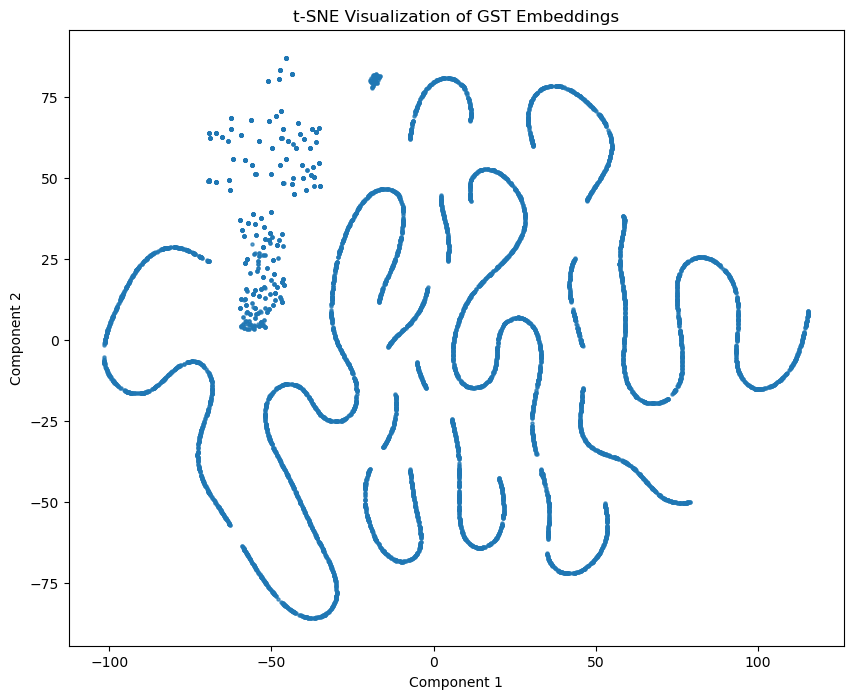

In [77]:
# Vizualization
"""
Visualize space and try to listen to examples of some clusters you've noticed in the map
"""

plt.figure(figsize=(10, 8))
plt.scatter(GSTEmbedded[:, 0], GSTEmbedded[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of GST Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# GST estimator

In [35]:
class StyleEmbeddingEstimator(nn.Module):
    """
    Estimator takes encoder outputs and returns style embeddings
    You can use some aggregation layers here: GRU or FFT + FC and some dropout for regularization
    Output dimension should be hparams.symbols_embedding_dim
    """
    def __init__(self, hparams):
        super(StyleEmbeddingEstimator, self).__init__()
    
        self.gru = nn.GRU(
            input_size=hparams.symbols_embedding_dim, 
            hidden_size=hparams.symbols_embedding_dim, 
            num_layers=1, 
            batch_first=True, 
            bidirectional=True
        )
        
        self.fc = nn.Linear(hparams.symbols_embedding_dim * 2, hparams.symbols_embedding_dim)
        self.dropout = nn.Dropout(hparams.p_gst_dropout)
        
    def forward(self, x, lengths):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.gru(packed_x)
        gru_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        gru_output = self.dropout(gru_output) 
        pooled_output = torch.mean(gru_output, dim=1)
        style_embedding = self.fc(pooled_output)
        
        return style_embedding

In [36]:
def load_gst_estimator_checkpoint(predictor, optimizer, filepath):
    checkpoint = torch.load(filepath, map_location="cpu")
    predictor.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return checkpoint['step'], checkpoint['min_eval_loss']


def save_gst_estimator_checkpoint(filepath, step, min_eval_loss, model, optimizer):
    checkpoint = {
        "step": step,
        'min_eval_loss': min_eval_loss,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(checkpoint, filepath)

In [37]:
def train_gst_estimator(dataset_dir, train_filelist_path, val_filelist_path, 
          fastpitch_checkpoint_path, logdir):
    fastpitch_checkpoint = torch.load(fastpitch_checkpoint_path)
    hparams = HParamsFastpitch(fastpitch_checkpoint['params'])
    fastpitch = FastPitch(hparams).to(device)
    load_from_checkpoint(fastpitch, fastpitch_checkpoint['state_dict'])
    fastpitch.eval()
    
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(hparams.seed)
    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    if not os.path.exists(logdir):
        os.makedirs(logdir)
    train_writer = SummaryWriter(os.path.join(logdir, "train"))
    val_writer = SummaryWriter(os.path.join(logdir, "val"))
    
    gst_estimator = StyleEmbeddingEstimator(hparams).to(device)
    
    optimizer = torch.optim.Adam(gst_estimator.parameters(), lr=hparams.gst_estimator_lr)
    
    train_loader, eval_loader = prepare_loaders(dataset_dir, train_filelist_path, val_filelist_path, hparams)
    
    step = 0
    min_eval_loss = np.inf

    checkpoint_path = os.path.join(logdir, f"GST_estimator_best_checkpoint.pt")
    if os.path.isfile(checkpoint_path):
        print("Resume training from checkpoint: ", checkpoint_path)
        step, min_eval_loss = load_gst_estimator_checkpoint(gst_estimator, optimizer, checkpoint_path)
  
    losses = []
    gst_estimator.train()
    while True:
        for batch in train_loader:
            x, y = batch_to_device(batch, device)
            """
            First, get the GT values for styles and encoder_state:
            """
            with torch.no_grad():
                _, _, mels, mel_lengths, _, _ = x
                gst_true, _ = fastpitch.gst(mels.transpose(1, 2), mel_lengths)
                enc_out, _ = fastpitch.encoder(x[0], x[1])
                
            optimizer.zero_grad()
            gst_pred = gst_estimator(enc_out, x[1])
                
            """
            It is better to train GST estimator as l1 regression
            """
            loss = torch.nn.L1Loss()(gst_pred, gst_true.mean(dim=1))
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            step += 1
            
            if step % hparams.gst_estimator_eval_interval == 0:
                train_writer.add_scalar('loss', np.mean(losses), step)
                print(f"train: {step:<3d} loss: {np.mean(losses):<5.4f}")
                
                eval_losses = []
                gst_estimator.eval()
                for batch in eval_loader:
                    x, y = batch_to_device(batch, device)
                    
                    """
                    The same, but for validation:
                    """
                    with torch.no_grad():
                        _, _, mels, mel_lengths, _, _ = x
                        gst_true, _ = fastpitch.gst(mels.transpose(1, 2), mel_lengths)
                        enc_out, _ = fastpitch.encoder(x[0], x[1])
                        gst_pred = gst_estimator(enc_out, x[1])
                        loss = torch.nn.L1Loss()(gst_pred, gst_true.mean(dim=1))
                        eval_losses.append(loss.item())
                        
                val_writer.add_scalar('loss', np.mean(eval_losses), step)
                print(f"val: {step:<3d} loss: {np.mean(eval_losses):<5.4f}")
                
                """
                Fallback to the prev model if the new one is not better:
                """
                if np.mean(losses) < min_eval_loss:
                    min_eval_loss = np.mean(eval_losses)
                    checkpoint_path = os.path.join(logdir, f"GST_estimator_best_checkpoint.pt")
                    save_gst_estimator_checkpoint(checkpoint_path, step, min_eval_loss, gst_estimator, optimizer)
                                
                for w in train_writer.all_writers.values():
                    w.flush()
                for w in val_writer.all_writers.values():
                    w.flush()
                 
                if step >= hparams.gst_estimator_num_steps:
                    exit()
                
                losses = []
                gst_estimator.train()

In [ ]:
fastpitch_checkpoint_path = "logs_dir/0480000_snapshot.pth"

"""
Usually few hours is enough to train the model well
"""

train_gst_estimator(prepr_data_path, train_filelist_path, val_filelist_path, 
          fastpitch_checkpoint_path, gst_logs_dir)

Parameters redefinitions:
batch_size = 8
train: 100 loss: 0.0652
val: 100 loss: 0.0459
train: 200 loss: 0.0427
val: 200 loss: 0.0383
train: 300 loss: 0.0376
val: 300 loss: 0.0357
train: 400 loss: 0.0381
val: 400 loss: 0.0290
train: 500 loss: 0.0331
val: 500 loss: 0.0289
train: 600 loss: 0.0314
val: 600 loss: 0.0302
train: 700 loss: 0.0307
val: 700 loss: 0.0360
train: 800 loss: 0.0334
val: 800 loss: 0.0337
train: 900 loss: 0.0303
val: 900 loss: 0.0249
train: 1000 loss: 0.0280
val: 1000 loss: 0.0252
train: 1100 loss: 0.0260
val: 1100 loss: 0.0268
train: 1200 loss: 0.0258
val: 1200 loss: 0.0233
train: 1300 loss: 0.0246
val: 1300 loss: 0.0236
train: 1400 loss: 0.0231
val: 1400 loss: 0.0236
train: 1500 loss: 0.0249
val: 1500 loss: 0.0253
train: 1600 loss: 0.0220
val: 1600 loss: 0.0273
train: 1700 loss: 0.0217
val: 1700 loss: 0.0226
train: 1800 loss: 0.0218
val: 1800 loss: 0.0220
train: 1900 loss: 0.0216
val: 1900 loss: 0.0200
train: 2000 loss: 0.0220
val: 2000 loss: 0.0212
train: 2100 loss:

val: 16800 loss: 0.0166
train: 16900 loss: 0.0168
val: 16900 loss: 0.0158
train: 17000 loss: 0.0176
val: 17000 loss: 0.0185
train: 17100 loss: 0.0167
val: 17100 loss: 0.0185
train: 17200 loss: 0.0176
val: 17200 loss: 0.0171
train: 17300 loss: 0.0179
val: 17300 loss: 0.0182
train: 17400 loss: 0.0171
val: 17400 loss: 0.0189
train: 17500 loss: 0.0167
val: 17500 loss: 0.0203
train: 17600 loss: 0.0163
val: 17600 loss: 0.0217
train: 17700 loss: 0.0174
val: 17700 loss: 0.0197
train: 17800 loss: 0.0177
val: 17800 loss: 0.0173
train: 17900 loss: 0.0164
val: 17900 loss: 0.0184
train: 18000 loss: 0.0174
val: 18000 loss: 0.0193
train: 18100 loss: 0.0179
val: 18100 loss: 0.0171
train: 18200 loss: 0.0174
val: 18200 loss: 0.0170
train: 18300 loss: 0.0171
val: 18300 loss: 0.0175
train: 18400 loss: 0.0171
val: 18400 loss: 0.0205
train: 18500 loss: 0.0166
val: 18500 loss: 0.0158
train: 18600 loss: 0.0181
val: 18600 loss: 0.0230
train: 18700 loss: 0.0166
val: 18700 loss: 0.0164
train: 18800 loss: 0.0172


val: 33200 loss: 0.0196
train: 33300 loss: 0.0180
val: 33300 loss: 0.0214
train: 33400 loss: 0.0187
val: 33400 loss: 0.0186
train: 33500 loss: 0.0187
val: 33500 loss: 0.0174
train: 33600 loss: 0.0185
val: 33600 loss: 0.0179
train: 33700 loss: 0.0179
val: 33700 loss: 0.0178
train: 33800 loss: 0.0185
val: 33800 loss: 0.0189
train: 33900 loss: 0.0173
val: 33900 loss: 0.0191
train: 34000 loss: 0.0166
val: 34000 loss: 0.0185
train: 34100 loss: 0.0189
val: 34100 loss: 0.0193
train: 34200 loss: 0.0182
val: 34200 loss: 0.0175
train: 34300 loss: 0.0176
val: 34300 loss: 0.0171
train: 34400 loss: 0.0176
val: 34400 loss: 0.0253
train: 34500 loss: 0.0185
val: 34500 loss: 0.0173
train: 34600 loss: 0.0177
val: 34600 loss: 0.0177
train: 34700 loss: 0.0162
val: 34700 loss: 0.0177
train: 34800 loss: 0.0191
val: 34800 loss: 0.0176
train: 34900 loss: 0.0178
val: 34900 loss: 0.0162
train: 35000 loss: 0.0182
val: 35000 loss: 0.0165
train: 35100 loss: 0.0179
val: 35100 loss: 0.0178
train: 35200 loss: 0.0179


val: 49600 loss: 0.0228
train: 49700 loss: 0.0214
val: 49700 loss: 0.0208
train: 49800 loss: 0.0215
val: 49800 loss: 0.0216
train: 49900 loss: 0.0220
val: 49900 loss: 0.0214
train: 50000 loss: 0.0229
val: 50000 loss: 0.0254
train: 50100 loss: 0.0228
val: 50100 loss: 0.0277
train: 50200 loss: 0.0242
val: 50200 loss: 0.0208
train: 50300 loss: 0.0226
val: 50300 loss: 0.0214
train: 50400 loss: 0.0228
val: 50400 loss: 0.0200
train: 50500 loss: 0.0210
val: 50500 loss: 0.0199
train: 50600 loss: 0.0215
val: 50600 loss: 0.0206
train: 50700 loss: 0.0219
val: 50700 loss: 0.0199
train: 50800 loss: 0.0233
val: 50800 loss: 0.0251
train: 50900 loss: 0.0240
val: 50900 loss: 0.0271
train: 51000 loss: 0.0238
val: 51000 loss: 0.0208
train: 51100 loss: 0.0221
val: 51100 loss: 0.0200
train: 51200 loss: 0.0216
val: 51200 loss: 0.0228
train: 51300 loss: 0.0219
val: 51300 loss: 0.0210
train: 51400 loss: 0.0216
val: 51400 loss: 0.0228
train: 51500 loss: 0.0217
val: 51500 loss: 0.0216
train: 51600 loss: 0.0211


val: 66000 loss: 0.0233
train: 66100 loss: 0.0244
val: 66100 loss: 0.0223
train: 66200 loss: 0.0219
val: 66200 loss: 0.0201
train: 66300 loss: 0.0225
val: 66300 loss: 0.0281
train: 66400 loss: 0.0237
val: 66400 loss: 0.0239
train: 66500 loss: 0.0212
val: 66500 loss: 0.0236
train: 66600 loss: 0.0231
val: 66600 loss: 0.0284
train: 66700 loss: 0.0235
val: 66700 loss: 0.0231
train: 66800 loss: 0.0240
val: 66800 loss: 0.0255
train: 66900 loss: 0.0233
val: 66900 loss: 0.0245
train: 67000 loss: 0.0235
val: 67000 loss: 0.0237
train: 67100 loss: 0.0241
val: 67100 loss: 0.0222
train: 67200 loss: 0.0247
val: 67200 loss: 0.0284
train: 67300 loss: 0.0236
val: 67300 loss: 0.0257
train: 67400 loss: 0.0237
val: 67400 loss: 0.0235
train: 67500 loss: 0.0220
val: 67500 loss: 0.0293
train: 67600 loss: 0.0224
val: 67600 loss: 0.0205
train: 67700 loss: 0.0225
val: 67700 loss: 0.0284
train: 67800 loss: 0.0248
val: 67800 loss: 0.0252
train: 67900 loss: 0.0235
val: 67900 loss: 0.0248
train: 68000 loss: 0.0225


val: 82400 loss: 0.0238
train: 82500 loss: 0.0251
val: 82500 loss: 0.0238
train: 82600 loss: 0.0247
val: 82600 loss: 0.0226
train: 82700 loss: 0.0245
val: 82700 loss: 0.0227
train: 82800 loss: 0.0252
val: 82800 loss: 0.0348
train: 82900 loss: 0.0270
val: 82900 loss: 0.0234
train: 83000 loss: 0.0256
val: 83000 loss: 0.0232
train: 83100 loss: 0.0277
val: 83100 loss: 0.0230
train: 83200 loss: 0.0260
val: 83200 loss: 0.0281
train: 83300 loss: 0.0242
val: 83300 loss: 0.0344
train: 83400 loss: 0.0246
val: 83400 loss: 0.0224
train: 83500 loss: 0.0255
val: 83500 loss: 0.0228
train: 83600 loss: 0.0254
val: 83600 loss: 0.0222
train: 83700 loss: 0.0278
val: 83700 loss: 0.0272
train: 83800 loss: 0.0267
val: 83800 loss: 0.0356
train: 83900 loss: 0.0271
val: 83900 loss: 0.0242
train: 84000 loss: 0.0252
val: 84000 loss: 0.0240
train: 84100 loss: 0.0236
val: 84100 loss: 0.0237
train: 84200 loss: 0.0252
val: 84200 loss: 0.0253
train: 84300 loss: 0.0263
val: 84300 loss: 0.0250
train: 84400 loss: 0.0267


val: 98800 loss: 0.0260
train: 98900 loss: 0.0278
val: 98900 loss: 0.0270
train: 99000 loss: 0.0280
val: 99000 loss: 0.0305
train: 99100 loss: 0.0257
val: 99100 loss: 0.0361
train: 99200 loss: 0.0281
val: 99200 loss: 0.0253
train: 99300 loss: 0.0257
val: 99300 loss: 0.0234
train: 99400 loss: 0.0264
val: 99400 loss: 0.0259
train: 99500 loss: 0.0267
val: 99500 loss: 0.0257
train: 99600 loss: 0.0275
val: 99600 loss: 0.0230
train: 99700 loss: 0.0259
val: 99700 loss: 0.0228
train: 99800 loss: 0.0272
val: 99800 loss: 0.0245
train: 99900 loss: 0.0285
val: 99900 loss: 0.0270
train: 100000 loss: 0.0258
val: 100000 loss: 0.0242
train: 100100 loss: 0.0279
val: 100100 loss: 0.0264
train: 100200 loss: 0.0262
val: 100200 loss: 0.0268
train: 100300 loss: 0.0260
val: 100300 loss: 0.0243
train: 100400 loss: 0.0263
val: 100400 loss: 0.0253
train: 100500 loss: 0.0277
val: 100500 loss: 0.0268
train: 100600 loss: 0.0286
val: 100600 loss: 0.0289
train: 100700 loss: 0.0299
val: 100700 loss: 0.0265
train: 100

In [38]:
gst_estimator_checkpoint_path = os.path.join(gst_logs_dir, "GST_estimator_best_checkpoint.pt")
fastpitch_checkpoint_path = "logs_dir/0482000_snapshot.pth"

# Full model inference

## Load waveglow checkpoint

Here we are using the same vocoder -- waveglow

In [41]:
wg_url = "https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_amp_256/versions/20.01.0/zip"
wg_checkpoint_path = os.path.join(pretrained_models_path, "waveglow")
wg_zip_path = os.path.join(pretrained_models_path, "waveglow.zip")
wg_unpacked_path = os.path.join(pretrained_models_path, 'nvidia_waveglow256pyt_fp16.pt')

In [39]:
getfile(wg_url, wg_zip_path)
shutil.unpack_archive(wg_zip_path, pretrained_models_path)
shutil.move(wg_unpacked_path, wg_checkpoint_path)
os.remove(wg_zip_path)

Downloading: 99% [980090880 / 980700967] bytes

In [47]:
def inference(wg_checkpoint_path, fastpitch_checkpoint_path, gst_estimator_checkpoint_path,
              test_texts, synth_wavs_path):
    wg_checkpoint = torch.load(wg_checkpoint_path)
    waveglow = WaveGlow(**wg_checkpoint['config']).to(device)
    load_from_checkpoint(waveglow, wg_checkpoint['state_dict'])
    waveglow = waveglow.remove_weightnorm(waveglow)
    waveglow.eval()
    
    denoiser = Denoiser(waveglow).to(device)
    
    fastpitch_checkpoint = torch.load(fastpitch_checkpoint_path)
    hparams = HParamsFastpitch(fastpitch_checkpoint['params'])
    
    fastpitch = FastPitch(hparams).to(device)
    load_from_checkpoint(fastpitch, fastpitch_checkpoint['state_dict'])
    fastpitch.eval()
    
    gst_estimator_checkpoint = torch.load(gst_estimator_checkpoint_path)
    gst_estimator = StyleEmbeddingEstimator(hparams).to(device)
    load_from_checkpoint(gst_estimator, gst_estimator_checkpoint['state_dict'])
    gst_estimator.eval()
    
    texts_encoded = [(fid, tp.encode_text(txt)) for fid, txt in test_texts.items()]

    if not os.path.exists(synth_wavs_path):
        os.mkdir(synth_wavs_path)
    
    for fid, text in tqdm.tqdm(texts_encoded):
        with torch.no_grad():
            text = torch.LongTensor(text)
            text_length = torch.LongTensor([text.size(0)]).to(device)
            text = text.unsqueeze(0).to(device)
            mel_pred = fastpitch.infer((text, text_length), gst_estimator)
            audio_pred = waveglow.infer(mel_pred, sigma=hparams.wg_sigma_infer)
            audio_pred = denoiser(audio_pred.float(), strength=hparams.wg_denoising_strength)
            audio_pred = audio_pred.squeeze(0).squeeze(0).cpu().numpy()

            wavfile.write(os.path.join(synth_wavs_path, fid + ".wav"), hparams.sample_rate, 
                          (np.clip(audio_pred, -1, 1) * 32767).astype(np.int16))
    

#### Check yourself:

In [48]:
inference(wg_checkpoint_path, fastpitch_checkpoint_path, gst_estimator_checkpoint_path, 
          {"TST": "The quick brown fox jumps over the lazy dog."}, synth_wavs_path)

Parameters redefinitions:
batch_size = 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


In [49]:
ipd.display(ipd.Audio('synth_wavs/TST.wav'))

# The test
Here is the estimation of your model:

you should render records from the given file 'test_texts.txt' ,
they should be intelligible and correspond to the text:

In [50]:
with open('test_texts.txt') as ifile:
    test_data = {
        "S{:03}_test".format(i): l.strip()
        for i, l in enumerate(ifile)
    }
    
sorted(test_data.items())

[('S000_test', 'In a hole in the ground there lived a hobbit.'),
 ('S001_test',
  'Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell,'),
 ('S002_test',
  'nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat:'),
 ('S003_test', 'it was a hobbit-hole, and that means comfort.'),
 ('S004_test',
  'It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle.'),
 ('S005_test', 'The door opened on to a tube-shaped hall like a tunnel:'),
 ('S006_test',
  'a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors.'),
 ('S007_test',
  'The tunnel wound on and on, going fairly but not quite straight into the side of the hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of it, first on one side an

In [51]:
inference(wg_checkpoint_path, fastpitch_checkpoint_path, gst_estimator_checkpoint_path, 
          test_data, synth_wavs_path)

Parameters redefinitions:
batch_size = 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.42it/s]


In [52]:
for fid, text in sorted(test_data.items()):
    print(fid)
    print(text)
    wav_filename = os.path.join(synth_wavs_path, fid + ".wav")
    ipd.display(ipd.Audio(wav_filename))
    print("----------")

S000_test
In a hole in the ground there lived a hobbit.


----------
S001_test
Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell,


----------
S002_test
nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat:


----------
S003_test
it was a hobbit-hole, and that means comfort.


----------
S004_test
It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle.


----------
S005_test
The door opened on to a tube-shaped hall like a tunnel:


----------
S006_test
a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors.


----------
S007_test
The tunnel wound on and on, going fairly but not quite straight into the side of the hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of it, first on one side and then on another.


----------
S008_test
No going upstairs for the hobbit: bedrooms, bathrooms, cellars, pantries (lots of these), wardrobes (he had whole rooms devoted to clothes), kitchens, dining-rooms, all were on the same floor, and indeed on the same passage.


----------
S009_test
The best rooms were all on the left-hand side (going in), for these were the only ones to have windows, deep-set round windows looking over his garden, and meadows beyond, sloping down to the river.


----------
S010_test
This hobbit was a very well-to-do hobbit, and his name was Baggins.


----------
S011_test
The Bagginses had lived in the neighbourhood of The Hill for time out of mind, and people considered them very respectable, not only because most of them were rich, but also because they never had any adventures or did anything unexpected:


----------
S012_test
you could tell what a Baggins would say on any question without the bother of asking him.


----------
S013_test
This is a story of how a Baggins had an adventure, and found himself doing and saying things altogether unexpected.


----------
S014_test
He may have lost the neighbours' respect, but he gained - well, you will see whether he gained anything in the end.


----------
